## Overview

Develop a sentiment analysis model using NLP techniques based on emotions dataset

Dataset: https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp/data



### Importing the libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re

## Data loading

Loading the dataset as dataframes

In [ ]:
df_train = pd.read_csv("train.txt", delimiter=';',names=['text','label'])
df_val = pd.read_csv("val.txt", delimiter=';',names=['text','label'])

In [ ]:
df_train.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
df_val.head()

,text,label
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


## Data Concatenation

Concatenating the training and validation DataFrames into a single unified dataset, as we have a separate test dataset.


In [ ]:
df_full = pd.concat([df_train, df_val], axis=0).reset_index(drop=True)
print(f"Shape of df_full: {df_full.shape}")
df_full.head()

Shape of df_full: (18000, 2)


,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


## Data Cleaning

Cleaning the text data in df_full by removing special characters, ensuring lowercase consistency, and handling duplicates.


In [ ]:
def clean_text(text):
    # Remove special characters and punctuation, keep alphanumeric and spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

# Record initial shape
initial_shape = df_full.shape
print(f"Initial shape: {initial_shape}")

# 1. Convert to lowercase
df_full['text'] = df_full['text'].str.lower()

# 2. Apply cleaning function
df_full['text'] = df_full['text'].apply(clean_text)

# 3. Handle duplicates
df_full = df_full.drop_duplicates().reset_index(drop=True)

# 4. Handle missing values
df_full = df_full.dropna(subset=['text', 'label'])

# 5. Print final shape
final_shape = df_full.shape
print(f"Final shape: {final_shape}")
print(f"Removed {initial_shape[0] - final_shape[0]} records.")
df_full.head()

Initial shape: (18000, 2)
Final shape: (17999, 2)
Removed 1 records.


,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


## Feature Engineering

Creating new features such as text length, word count, and average word length to assist in the exploratory analysis.


In [ ]:
import numpy as np

# 1. Calculate text length (character count)
df_full['text_length'] = df_full['text'].apply(len)

# 2. Calculate word count
df_full['word_count'] = df_full['text'].apply(lambda x: len(x.split()))

# 3. Calculate average word length
# Use a lambda to avoid division by zero if any empty strings exist
df_full['avg_word_length'] = df_full.apply(lambda row: row['text_length'] / row['word_count'] if row['word_count'] > 0 else 0, axis=1)

# 4. Display the first few rows
print("Features engineered successfully.")
df_full.head()

Features engineered successfully.


,text,label,text_length,word_count,avg_word_length
0,i didnt feel humiliated,sadness,23,4,5.750000
1,i can go from feeling so hopeless to so damned...,sadness,108,21,5.142857
2,im grabbing a minute to post i feel greedy wrong,anger,48,10,4.800000
3,i am ever feeling nostalgic about the fireplac...,love,92,18,5.111111
4,i am feeling grouchy,anger,20,4,5.000000


## Exploratory Data Analysis (EDA) & Visualization

Analyzing the distribution of emotion labels and text features


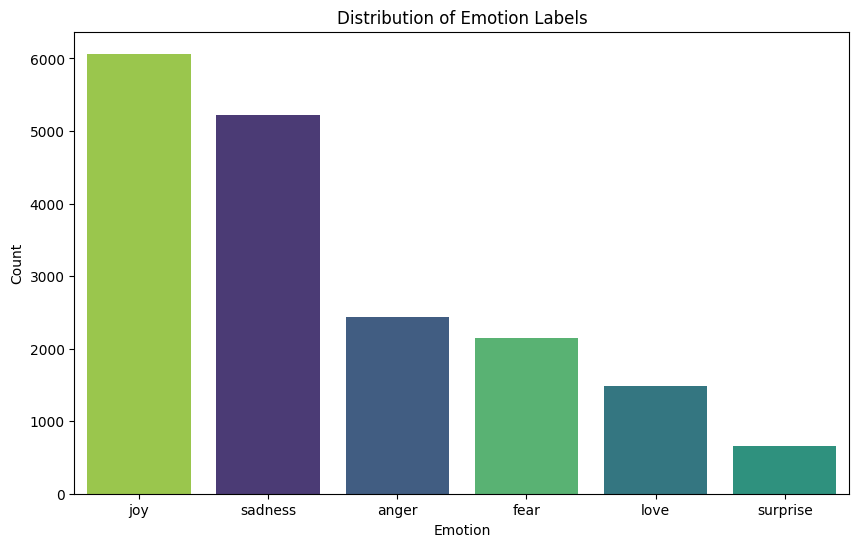

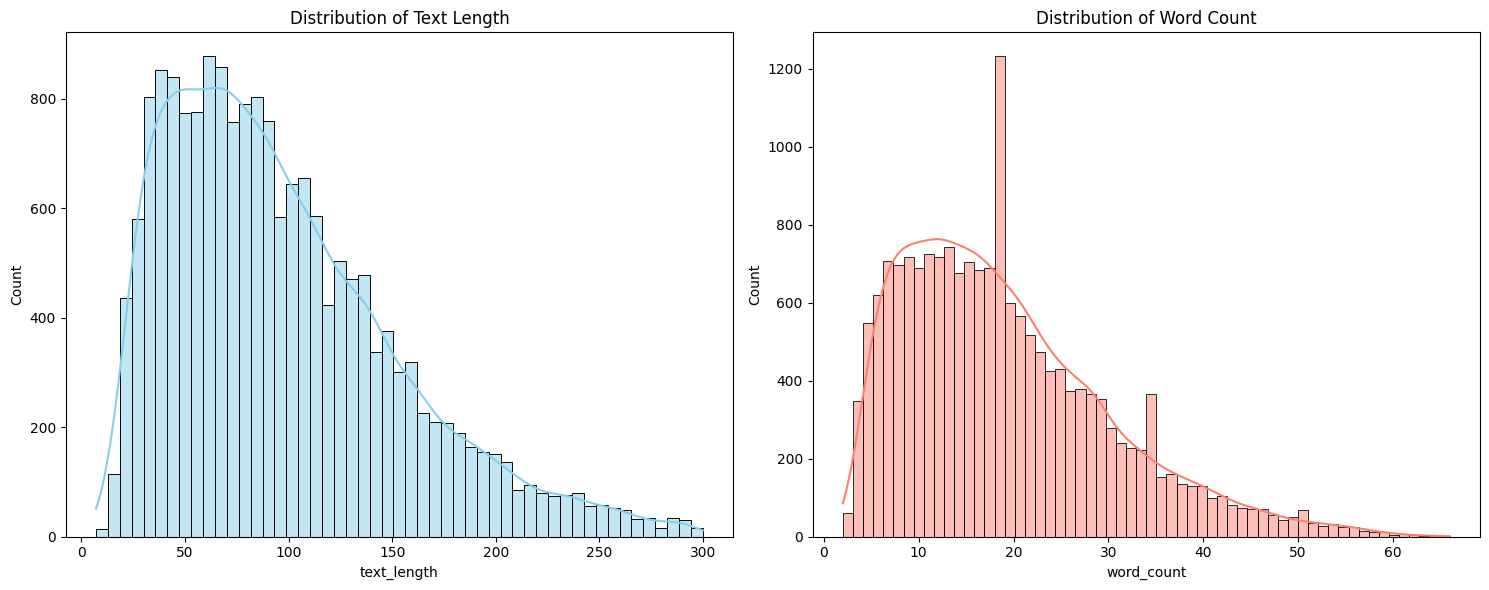

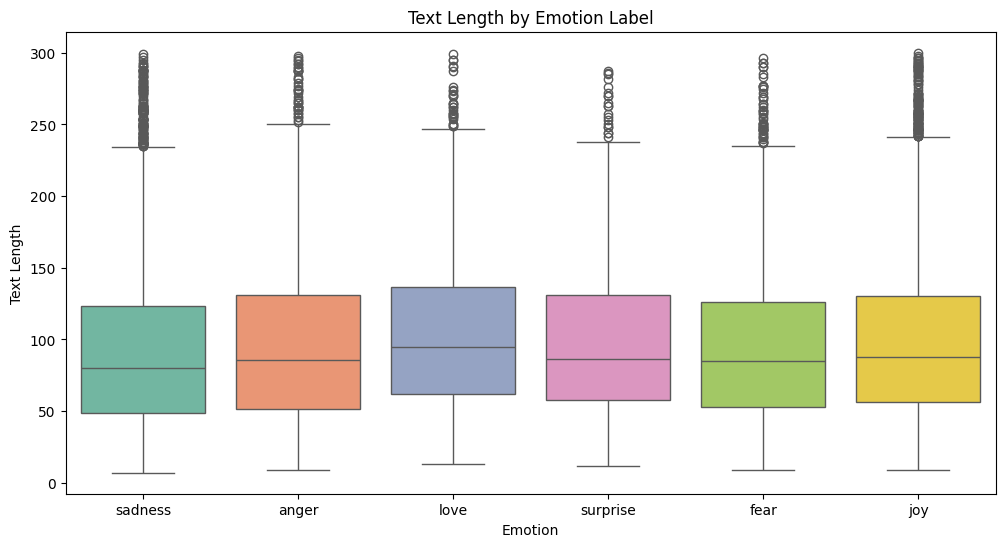

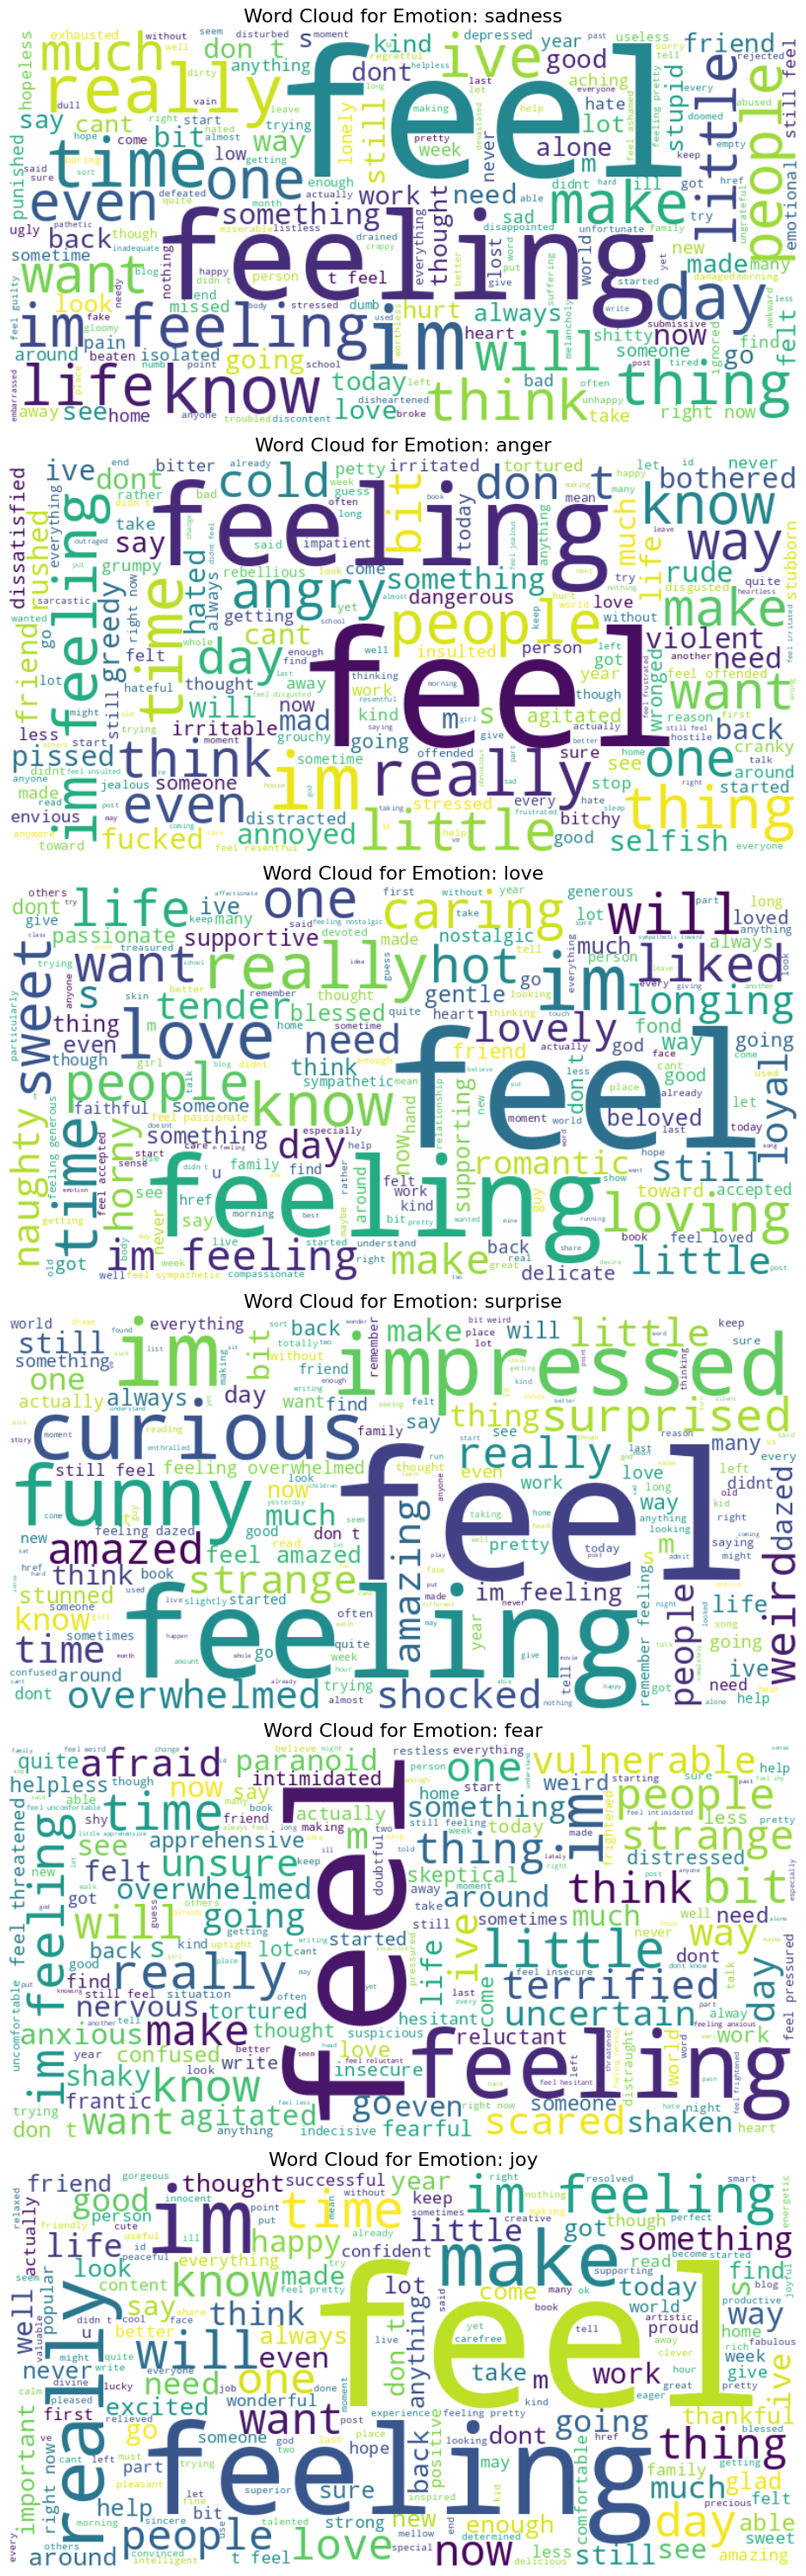

In [ ]:
# 1. Label distribution count plot
plt.figure(figsize=(10, 6))
sns.countplot(data=df_full, x='label', order=df_full['label'].value_counts().index, palette='viridis', hue='label', legend=False)
plt.title('Distribution of Emotion Labels')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

# 2. Histograms for text_length and word_count
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(df_full['text_length'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Text Length')
sns.histplot(df_full['word_count'], kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Distribution of Word Count')
plt.tight_layout()
plt.show()

# 3. Box plot: text_length by label
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_full, x='label', y='text_length', palette='Set2', hue='label', legend=False)
plt.title('Text Length by Emotion Label')
plt.xlabel('Emotion')
plt.ylabel('Text Length')
plt.show()

# 4. Word Clouds for each emotion
emotions = df_full['label'].unique()
fig, axes = plt.subplots(len(emotions), 1, figsize=(10, 5 * len(emotions)))

for i, emotion in enumerate(emotions):
    text_data = " ".join(df_full[df_full['label'] == emotion]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Word Cloud for Emotion: {emotion}', fontsize=16)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Baseline Model Development

Preparing the data using TF-IDF vectorization, train a Multinomial Naive Bayes classifier, and evaluate its performance.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 1. Define feature matrix X and target vector y
X = df_full['text']
y = df_full['label']

# 2. Split the data into training and testing sets
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Initialize TfidfVectorizer and transform the text data
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train_raw)
X_test_tfidf = tfidf.transform(X_test_raw)

# 4. Initialize and train the Multinomial Naive Bayes classifier
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# 5. Generate predictions and evaluate the model
y_pred = model.predict(X_test_tfidf)
print("Baseline Model: Multinomial Naive Bayes Classification Report")
# Use zero_division=0 to handle cases where classes are not predicted
print(classification_report(y_test, y_pred, zero_division=0))

Baseline Model: Multinomial Naive Bayes Classification Report
              precision    recall  f1-score   support

       anger       0.96      0.18      0.31       500
        fear       0.85      0.10      0.18       399
         joy       0.54      0.99      0.70      1150
        love       1.00      0.02      0.04       304
     sadness       0.71      0.87      0.79      1109
    surprise       0.00      0.00      0.00       138

    accuracy                           0.62      3600
   macro avg       0.68      0.36      0.34      3600
weighted avg       0.71      0.62      0.53      3600



## Summary:


**Data Preparation:**
The "train.txt" and "val.txt" files were concatenated into a single dataset of 18,000 records. Cleaning involved converting text to lowercase, removing special characters via regex, and dropping one duplicate record to result in a final count of 17,999.

**Feature Engineering:**
Three numerical features were created: `text_length` (character count), `word_count`, and `avg_word_length` (the ratio of characters to words).

**Baseline Model:**
The Multinomial Naive Bayes model, using TF-IDF vectorization, achieved an overall accuracy of 62%. While it showed high precision for specific labels like `anger` (0.96) and `love` (1.00), it struggled with recall for minority classes and completely failed to predict the `surprise` category.

### Data Analysis Key Findings

*   **Imbalanced Emotion Distribution**: EDA revealed that the dataset is dominated by the `joy` and `sadness` classes, which directly influenced the model's ability to learn.
*   **Text Metrics**: Most entries follow a consistent distribution of length and word count, though box plots indicated slight variations in expression length across different emotional categories.
*   **Model Bias**: The baseline model exhibits a strong bias toward majority classes. For example, `sadness` achieved an F1-score of 0.79, while `surprise` resulted in an F1-score of 0.00 due to zero predictions.
*   **Precision vs. Recall Gap**: There is a significant disparity in model performance; for instance, the model is extremely cautious with the `love` label (0.02 recall) but highly accurate when it does choose to apply it (1.00 precision).

### Next Steps

*   **Address Class Imbalance**: Future iterations should implement oversampling techniques (like SMOTE) or undersampling of majority classes to improve the recall of minority emotions like `surprise` and `love`.
*   **Model Upgrade**: Given the limitations of Multinomial Naive Bayes on this specific text data, transitioning to more sophisticated models such as Support Vector Machines (SVM), Random Forests, or transformer-based models (e.g., BERT) would likely significantly improve accuracy beyond 62%.
